In [1]:
using WoodburyMatrices

using Interpolations
import Interpolations: prefiltering_system,
                       inner_system_diags,
                       lut!,
                       prefilter, prefilter!,
                       copy_with_padding, positions, 
                       roundbounds, fast_trunc, expand_index

import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

In [2]:
function positions(deg::Quadratic, ax, x)
    xm = roundbounds(x, ax)
    δx = x - xm
    expand_index(deg, fast_trunc(Int, xm), ax, δx), δx
end

function prefiltering_system(::Type{T}, ::Type{TC}, n::Int, degree::Quadratic{<:Line}) where {T,TC}
    dl,d,du = inner_system_diags(T,n,degree)
    d[1] = d[end] = 1
    du[1] = dl[end] = -2
    @show d

    specs = WoodburyMatrices.sparse_factors(T, n,
                                  (1, 3, oneunit(T)),
                                  (n, n-2, oneunit(T)),
                                  )
    
    b = zeros(TC, n)
    b[1] = 0
    b[end] = 0

    Woodbury(lut!(dl, d, du), specs...), b
end

function prefilter(
    ::Type{TWeights}, ::Type{TC}, A::AbstractArray,
    it::Union{BSpline,Tuple{Vararg{Union{BSpline,NoInterp}}}}
    ) where {TWeights,TC}
    ret = copy_with_padding(TC, A, it)
    prefilter!(TWeights, ret, it)
end

prefilter (generic function with 3 methods)

data = exp.(0.5knots) = [1.6487212707001282, 2.718281828459045, 4.4816890703380645, 7.38905609893065, 12.182493960703473, 20.085536923187668, 33.11545195869231, 54.598150033144236, 90.01713130052181, 148.4131591025766]
d = [1.0, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 1.0]
f.coefs = [0.6719529969151199, 1.648721270700128, 2.625489544485137, 4.344596090061412, 7.160446477850907, 11.805173834278348, 19.46846220210679, 32.068348338582275, 53.045063435938054, 86.44647131094331, 148.4131591025766, 210.37984689420983]
f(1) - f_ref_1(1) = 0.0
f(1.2) - f_ref_1(1.2) = 0.0
f(1.5) - f_ref_1(1.5) = 0.0
f(1.8) - f_ref_2(1.8) = 0.0
f(2) - f_ref_2(2) = 0.0
f(2.5) - f_ref_2(2.5) = 0.0


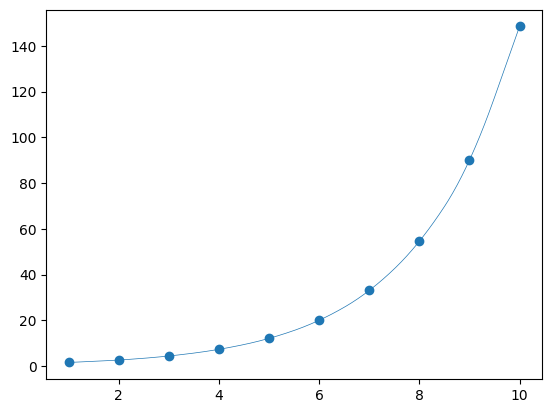

0.0

In [17]:
knots = 1:10
@show data = exp.(0.5*knots)

f = interpolate(data, BSpline(Quadratic(Line(OnGrid()))))
@show f.coefs

plt.scatter(knots, data, label="values at knots")

knots_fine = LinRange(1, 10, 500)
plt.plot(knots_fine, f.(knots_fine), lw=0.5, label="quadratic interpolation")

p1(δx) = (δx - 1/2)^2 / 2
p2(δx) = (δx + 1/2)^2 / 2
q(δx) = 0.75 - δx^2

i = 1
cm = 0.6719529969151199
c = 1.648721270700128
cp = 2.625489544485137
f_ref_1(x) = cm * p1(x-i) + c * q(x-i) + cp * p2(x-i)

@show f(1) - f_ref_1(1)
@show f(1.2) - f_ref_1(1.2)
@show f(1.5) - f_ref_1(1.5)

i = 2
cm = 1.648721270700128
c = 2.625489544485137
cp = 4.344596090061412
f_ref_2(x) = cm * p1(x-i) + c * q(x-i) + cp * p2(x-i)

@show f(1.8)- f_ref_2(1.8)
@show f(2) - f_ref_2(2)
@show f(2.5)- f_ref_2(2.5)

In [43]:
struct IncrementalSpline{T<:Number}
    knots::AbstractRange{T}
    data::Vector{T}
    der_data::Vector{T}
end

function IncrementalSpline(knots::AbstractRange{T}, val1::T, der1::T) where {T<:Number}
    data = T[val1]
    sizehint!(data, length(knots))
    der_data = T[der1 * step(knots)]
    sizehint!(der_data, length(knots)-1)
    return IncrementalSpline{T}(knots, data, der_data)
end

function extend!(spline::IncrementalSpline{T}, val) where {T<:Number}
   push!(spline.data, val)
   push!(spline.der_data, 2*(spline.data[end] - spline.data[end-1]) - spline.der_data[end])
end

function (spline::IncrementalSpline{T})(z) where {T<:Number}
    @assert first(spline.knots) <= z <= last(spline.knots)
    x = 1 + (z - first(spline.knots)) / step(spline.knots)
    i = floor(Int, x)
    i = min(i, length(spline.data) - 1)
    δx = x - i
    @inbounds c3 = spline.der_data[i] - 2 * spline.data[i + 1]
    @inbounds spline.data[i] * (1 - δx^2) + spline.data[i + 1] * (1 - (1-δx)^2) + c3 * (0.25 - (δx - 0.5)^2)
end

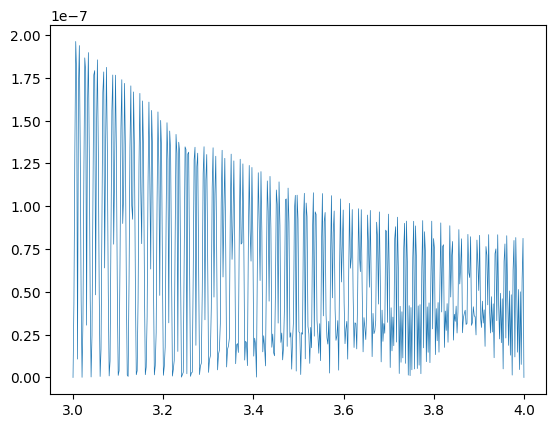

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbd7ba153f0>

In [44]:
f(x) = exp(2*x)

knots = LinRange(3, 4, 100)
data = f.(knots)
der1 = 2*data[1]

spline = IncrementalSpline(knots, data[1], der1)
for x in data[2:end]
    extend!(spline, x)
end

#plt.scatter(knots, data, label="values at knots")

knots_fine = LinRange(3, 4, 500)

diff = (f.(knots_fine) - spline.(knots_fine)) ./ f.(knots_fine)
plt.plot(knots_fine, abs.(diff), lw=0.5, label="quadratic interpolation")